<a href="https://colab.research.google.com/github/SvetlanaShkryleva/image-processing/blob/main/Practice_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ДЗ

1. Выполните сохранение монохромного изображения в виде текстового или бинарного
файла.

2. Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.

3. Выполните квантование высокочастотных компонент (прим., количество квантов = 4).

4. Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL,
LH, HL, HH вейвлет-преобразования Хафа. Компоненты LH, HL, HH храните в виде пар
(значение, количество повторений).

Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение), и
изображение, полученным после преобразования Хафа и сжатием длин серий.

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from collections import Counter

Изображение сохранено в файл 'monochrome_image.txt', размер изображения: (400, 600)


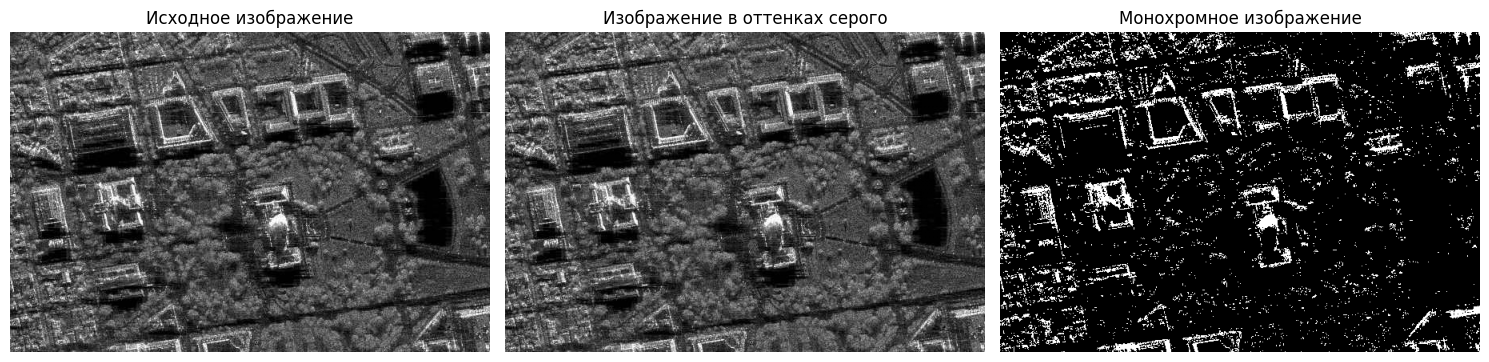

In [7]:
image = cv2.imread('sar_1_gray.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, monochrome_image = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY)

with open('monochrome_image.txt', 'w') as file:
    for row in monochrome_image:
        line = ' '.join(str(pixel) for pixel in row)
        file.write(line + '\n')

print(f"Изображение сохранено в файл 'monochrome_image.txt', размер изображения: {monochrome_image.shape}")
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image, cmap='gray'); plt.title('Исходное изображение'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(image_gray, cmap='gray'); plt.title('Изображение в оттенках серого'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(monochrome_image, cmap='gray'); plt.title('Монохромное изображение'); plt.axis('off')
plt.tight_layout()
plt.show()

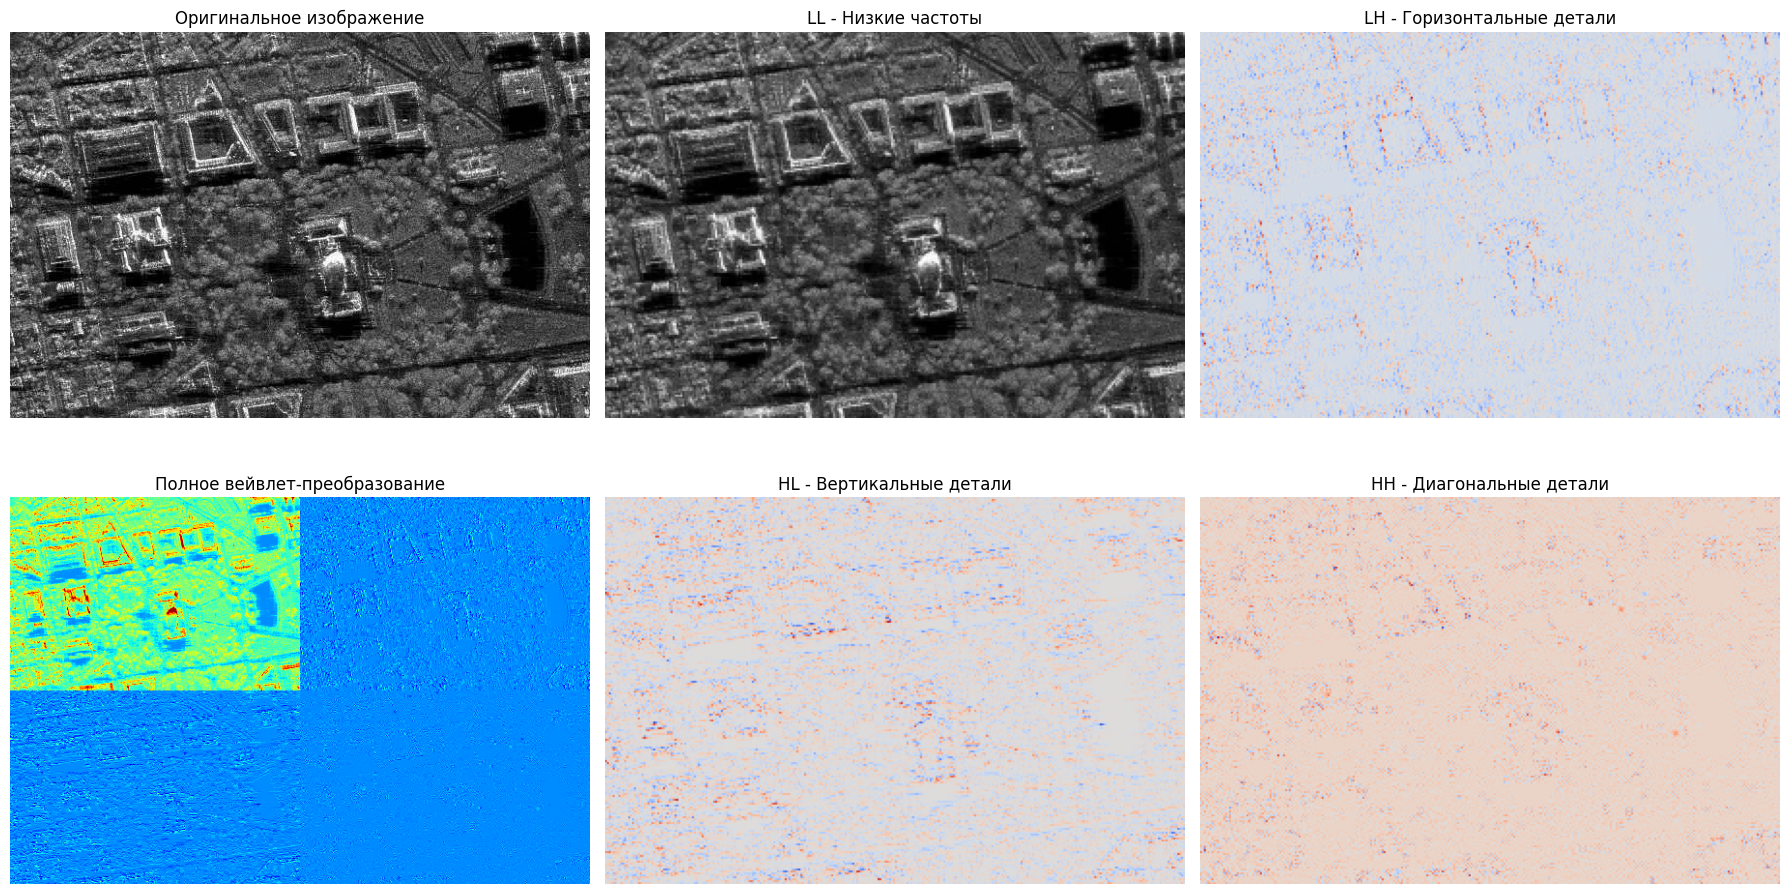

In [8]:
def haar_transform(image):
    image = image.astype(np.float32)
    h, w = image.shape

    temp = np.zeros_like(image)

    for i in range(h):
        for j in range(0, w, 2):
            if j + 1 < w:
                temp[i, j // 2] = (image[i, j] + image[i, j + 1]) / 2
                temp[i, j // 2 + w // 2] = (image[i, j] - image[i, j + 1]) / 2
            else:
                temp[i, j // 2] = image[i, j]

    result = np.zeros_like(temp)

    for j in range(w):
        for i in range(0, h, 2):
            if i + 1 < h:
                result[i // 2, j] = (temp[i, j] + temp[i + 1, j]) / 2
                result[i // 2 + h // 2, j] = (temp[i, j] - temp[i + 1, j]) / 2
            else:
                result[i // 2, j] = temp[i, j]

    ll = result[:h // 2, :w // 2]
    lh = result[:h // 2, w // 2:]
    hl = result[h // 2:, :w // 2]
    hh = result[h // 2:, w // 2:]

    return ll, lh, hl, hh, result

ll, lh, hl, hh, haar_result = haar_transform(image_gray)

plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1); plt.imshow(image, cmap='gray'); plt.title('Оригинальное изображение'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(haar_result, cmap='jet'); plt.title('Полное вейвлет-преобразование'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(ll, cmap='gray'); plt.title('LL - Низкие частоты'); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(lh, cmap='coolwarm'); plt.title('LH - Горизонтальные детали'); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(hl, cmap='coolwarm'); plt.title('HL - Вертикальные детали'); plt.axis('off')
plt.subplot(2, 3, 6); plt.imshow(hh, cmap='coolwarm'); plt.title('HH - Диагональные детали'); plt.axis('off')
plt.tight_layout()
plt.show()

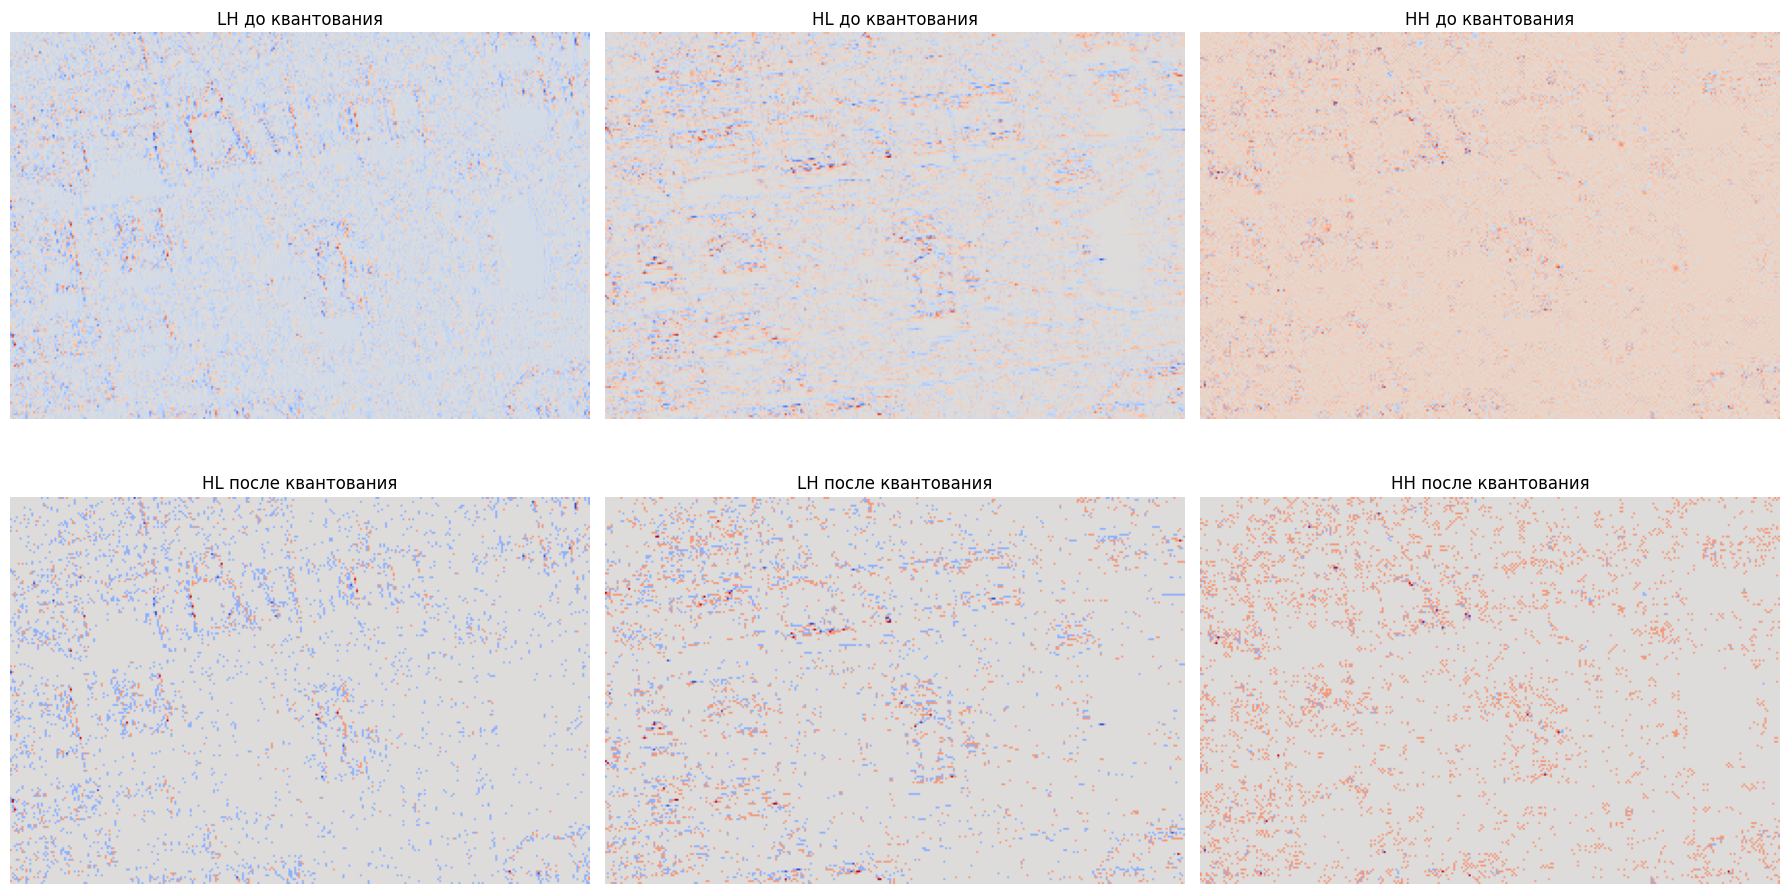

In [9]:
def quantize(coeffs, n_quants):
    min_val = np.min(coeffs)
    max_val = np.max(coeffs)
    step = (max_val - min_val) / n_quants
    quantized = np.round((coeffs - min_val) / step).astype(int)
    return quantized, min_val, step

num_quants=4
lh_quantize, lh_min, lh_step = quantize(lh, num_quants)
hl_quantize, hl_min, hl_step = quantize(hl, num_quants)
hh_quantize, hh_min, hh_step = quantize(hh, num_quants)

def dequantize(quantized, min_val, step):
    return min_val + quantized * step
lh_restored = dequantize(lh_quantize, lh_min, lh_step)
hl_restored = dequantize(hl_quantize, hl_min, hl_step)
hh_restored = dequantize(hh_quantize, hh_min, hh_step)

plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1); plt.imshow(lh, cmap='coolwarm'); plt.title('LH до квантования'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(hl, cmap='coolwarm'); plt.title('HL до квантования'); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(hh, cmap='coolwarm'); plt.title('HH до квантования'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(lh_restored, cmap='coolwarm'); plt.title('HL после квантования'); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(hl_restored, cmap='coolwarm'); plt.title('LH после квантования'); plt.axis('off')
plt.subplot(2, 3, 6); plt.imshow(hh_restored, cmap='coolwarm'); plt.title('HH после квантования'); plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
def run_length_encode(data):
    encoded = []
    for value, count in Counter(data.flatten()).items():
        encoded.append((value, count))
    return encoded

lh_rle = run_length_encode(lh_quantize)
hl_rle = run_length_encode(hl_quantize)
hh_rle = run_length_encode(hh_quantize)

with open('haar_components.txt', 'w') as file:
    np.savetxt(file, ll, fmt='%d')
    file.write('\n')

    components = [('LH', lh_rle), ('HL', hl_rle), ('HH', hh_rle)]
    for comp_name, rle_data in components:
        for value, count in rle_data:
            file.write(f"{value} {count}\n")
        file.write('\n')

print("Компоненты сохранены в файл 'haar_components.txt'")

Компоненты сохранены в файл 'haar_components.txt'


In [11]:
with open('monochrome_image.txt', 'r') as f:
    original_size = len(f.read().encode('utf-8'))

with open('haar_components.txt', 'r') as f:
    compressed_size = len(f.read().encode('utf-8'))

print(f"Хранение монохромного изображения в текстовом файле: : {original_size} байт")
print(f"Хранение изображения, обработанного преобразованием Хаара: : {compressed_size} байт")
print(f"Сжали в {original_size/compressed_size:.1f} раз")

Хранение монохромного изображения в текстовом файле: : 528542 байт
Хранение изображения, обработанного преобразованием Хаара: : 190885 байт
Сжали в 2.8 раз
